# Simulations with large ptychographic scan steps (ie sparse scans) and with low values for the scattering amplitudes (ie weak).

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
from tqdm import tqdm_notebook as tqdm

from mbptycho.code.simulation import *
from skimage.registration import phase_cross_correlation
from skimage.restoration import unwrap_phase
from scipy import io
import copy
import os

cmap = copy.copy(mpl.cm.get_cmap('coolwarm'))
cmap.set_bad('black')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
base_path = os.environ['HOME']

In [4]:
base_path

'/raid/home/skandel'

In [5]:
probe_2d = io.loadmat(f'{base_path}/code/mbptycho/experiments/matlab/datasets/recon_probe_29902.mat')["prb"]
probes_3d_path = f'{base_path}/code/mbptycho/experiments/matlab/datasets_0821/probes_4_peaks.mat'

In [6]:
probe_2d_hanning = probe_2d * np.hanning(100)**2 * np.hanning(100)[:,None]**2
np.sum(np.abs(probe_2d)**2), np.max(np.abs(probe_2d)**2)


(10825924.943706645, 523435.2684263936)

In [7]:
np.sum(np.abs(probe_2d_hanning)**2), np.max(np.abs(probe_2d_hanning)**2)

(9864436.414212773, 522382.08679216617)

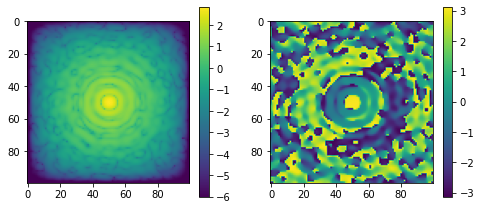

In [8]:
plt.figure(figsize=[8,3.5])
plt.subplot(121)
plt.imshow(np.log10(np.abs(probe_2d_hanning) + 1e-6))
plt.colorbar()
plt.subplot(122)
plt.imshow(np.angle(probe_2d))
plt.colorbar()
plt.show()

In [14]:
class SampleModified(Sample):
    def __init__(self, wavelength: float, sample_pix_size: float, sample_params: dict = None):#, z_nw_pad: float=2):

        if sample_params is None:
            sample_params = {}
        self.params = SampleParams(sample_pix_size=sample_pix_size,
                                   wavelength=wavelength,
                                   **sample_params)

        #self.z_nw_pad = z_nw_pad

        print("Depth of numerical window covers", self.params.sample_pix_size * self.params.npix_depth, "microns")

        self.x_full = np.arange(-self.params.npix_xy // 2, self.params.npix_xy // 2) * self.params.sample_pix_size
        self.y_full = np.arange(-self.params.npix_xy // 2, self.params.npix_xy // 2) * self.params.sample_pix_size
        self.z_full = (np.arange(-self.params.npix_depth // 2, self.params.npix_depth // 2) *
                       self.params.sample_pix_size)

        self.YY_full, self.XX_full, self.ZZ_full = np.meshgrid(self.y_full, self.x_full, self.z_full, indexing='ij')

        #deltay = self.params.sample_pix_size * self.params.npix_uncertainty_y
        #deltax = self.params.sample_pix_size * self.params.npix_uncertainty_x
        # z_pad = self.params.sample_pix_size * self.params.npix_pad_z
        #print('uncertainty', deltay, deltax)

        #self.obj_mask_w_delta = ((np.abs(self.YY_full) < (self.params.grain_height / 2 + deltay))
        #                         * (np.abs(self.XX_full) < (self.params.grain_width / 2 + deltax))
        #                         * (np.abs(self.ZZ_full) < (self.params.film_thickness / 2)))
        self.obj_mask_w_delta = ((np.abs(self.YY_full) < (self.params.grain_height_delta / 2 ))
                                 * (np.abs(self.XX_full) < (self.params.grain_width_delta / 2 ))
                                 * (np.abs(self.ZZ_full) < (self.params.film_thickness / 2)))
        self.obj_mask_full = ((np.abs(self.YY_full) < (self.params.grain_height / 2))
                              * (np.abs(self.XX_full) < (self.params.grain_width / 2))
                              * (np.abs(self.ZZ_full) < (self.params.film_thickness / 2)))

        self.makeStrains(self.params.strain_type)
        #self.truncateNumericalWindow(pad=self.z_nw_pad, xy_scan=True)
        self.rhos = None
        
    
    def _setStrainPointInclusion(self):
        self.strain_params = PointInclusionStrainParams()

        # getting the random terminii
        coords_all = np.stack([self.YY_full, self.XX_full], axis=-1).reshape(-1, 2)

        #rp = np.random.randint(low=0, high=self.obj_mask_full.sum(),
        #                      size=self.strain_params.n_inclusion)
        #terminii = coords_all[self.obj_mask_full.flat, :][rp, :]
        terminii = np.array([[-0.22208582,  0.34481745]])
        self.strain_params.coords_inclusion = terminii

        self.Ux_full = np.zeros_like(self.XX_full)
        self.Uy_full = np.zeros_like(self.XX_full)
        self.Uz_full = np.zeros_like(self.XX_full)
        for terminus in terminii:
            coords_rel = coords_all - terminus
            r = np.reshape(np.sqrt(np.sum(coords_rel ** 2, axis=1)), self.XX_full.shape)
            th = np.reshape(np.arctan2(coords_rel[:, 0], coords_rel[:, 1]), self.XX_full.shape)
            U = self.strain_params.mag * np.exp(-self.strain_params.alpha * r)
            Ux_this = U * np.cos(th)
            Uy_this = U * np.sin(th)
            self.Ux_full += Ux_this
            self.Uy_full += Uy_this

In [18]:
class SimulationModified(Simulation):
    def __init__(self, sim_params: dict = None,
                 extra_sample_params: dict = None):
                 #z_nw_pad: int=2):

        if sim_params is None:
            sim_params = {}
        self.params = SimulationParams(**sim_params)
        

        self.sample = SampleModified(wavelength=self.params.wavelength, sample_pix_size=self.params.sample_pix_size,
                                      sample_params=extra_sample_params)#, z_nw_pad=z_nw_pad)

        self.rhos = self.sample.setSampleRhos(
            HKL_list=self.params.HKL_list,
            magnitudes_scaling_per_peak=self.params.magnitudes_scaling_per_peak,
            random_scaled_magnitudes=self.params.random_scaled_magnitudes,
            magnitudes_max=self.params.magnitudes_max)

        self.probes_obj = Probes(self.params.HKL_list, self.params.probes_matlab_file)
        #self.probes = [p[:, :, self.sample.nw_zmin:self.sample.nw_zmax] for p in self.probes_obj.probes]
        self.probes = [p for p in self.probes_obj.probes]
        # theta, two_theta, gamma
        motor_list = np.array([-self.HKLToTheta(*HKL)
                               for HKL in self.params.HKL_list])
        self.motor_list_rad = motor_list
        
        # Using these redundant representations just for convenience
        self.thetas_deg, self.two_thetas_deg, self.gammas_deg = motor_list.T * 180 / np.pi
        self.thetas_rad, self.two_thetas_rad, self.gammas_rad = motor_list.T

        self.ptycho_scan_positions = self.getPtychoScanPositions(self.params.n_scan_positions,
                                                                 self.params.npix_scan_shift)
        self.simulations_per_peak = [SimulationPerBraggPeak(rho=self.rhos[i],
                                                            #rho_full=self.rhos[i],
                                                            probe=self.probes[i],
                                                            #probe_full=self.probes[i],
                                                            theta=self.thetas_rad[i],
                                                            two_theta=self.two_thetas_rad[i],
                                                            gamma=self.gammas_rad[i],
                                                            sample_params=self.sample.params,
                                                            ptycho_scan_positions=self.ptycho_scan_positions,
                                                            npix_det=self.params.npix_det,
                                                            #x_nw=self.sample.x_trunc,
                                                            #y_nw=self.sample.y_trunc,
                                                            #z_nw=self.sample.z_trunc,
                                                            x_full=self.sample.x_full,
                                                            y_full=self.sample.y_full,
                                                            z_full=self.sample.z_full,
                                                            poisson_noise=self.params.poisson_noise,
                                                            poisson_noise_level=self.params.poisson_noise_level)
                                     for i in range(len(self.rhos))]

In [19]:
strain_type = 'point_inclusion'

In [20]:
# The "magnitudes_scaling_per_peak" parameter sets the scattering amplitude per peak.

sm1 = SimulationModified(sim_params={'poisson_noise':False, 
                                    'probes_matlab_file':probes_3d_path, 
                                    'n_scan_positions':9,
                                    'npix_scan_shift':6,
                                      'HKL_list':np.array([[1, 2, 0]]),
                                     'magnitudes_scaling_per_peak': [0.4]},
                      extra_sample_params={'strain_type':strain_type, 
                                               'npix_delta_x':5,
                                               'npix_delta_y':5})
                       #z_nw_pad=2)
#sm1.sample.Ux_trunc.shape, sm1.sample.params.sample_pix_size

Depth of numerical window covers 0.5844363636363636 microns
Magnitude scaling per peak is supplied. Does not apply random scaling.
Loading probe from matlab data...
Loading successful...


In [21]:
sm1.sample.obj_mask_w_delta.sum()

237405

In [275]:
sm1.sample.obj_mask_full.sum()

197965

In [259]:
print(sm1.simulations_per_peak[0].diffraction_patterns.sum(axis=(1,2)))

[2294.38 2248.82 2253.67 2262.64 2283.19 2304.66 2317.36 2314.49 2280.75
 2265.06 2259.89 2265.94 2280.96 2301.5  2315.92 2322.8  2323.61 2305.62
 2253.88 2259.9  2268.38 2288.4  2303.96 2312.36 2319.6  2321.37 2315.4
 2251.77 2255.83 2271.78 2287.97 2297.59 2304.85 2310.91 2314.03 2310.26
 2247.9  2257.64 2273.67 2283.86 2291.27 2297.38 2302.4  2305.86 2297.87
 2244.91 2258.45 2270.12 2277.15 2283.79 2288.66 2293.96 2291.79 2278.74
 2244.27 2257.62 2266.15 2271.82 2276.76 2281.97 2283.19 2275.56 2261.42
 2241.3  2253.23 2258.38 2263.9  2267.22 2270.91 2266.67 2256.71 2250.13
 2227.38 2236.28 2241.47 2246.49 2250.44 2249.37 2241.79 2235.2  2239.25]


In [206]:
print(sm1.simulations_per_peak[0].diffraction_patterns.sum())

0.9125688966028722


In [157]:
projs = sm1.simulations_per_peak[0].projections
fields = sm1.simulations_per_peak[0].fields_before_rot

In [193]:
[diffraction_patterns1, 
 projections_all1, fields1] = sm1.simulations_per_peak[0].getDiffractionPatternsNew()

(200, 200, 26)
(slice(9, None, None), slice(9, None, None)) rho_shape (200, 200, 26)
probe sum 8731.951086598901 rho_sum 791.8600000000002 field_sum 21.686542488053604
(slice(9, None, None), slice(0, 200, None)) rho_shape (200, 200, 26)
probe sum 8731.951086598901 rho_sum 791.8600000000002 field_sum 21.708392215879794
(slice(0, 200, None), slice(9, None, None)) rho_shape (200, 200, 26)
probe sum 8731.951086598901 rho_sum 791.8600000000002 field_sum 21.80836296703475
(slice(0, 200, None), slice(0, 200, None)) rho_shape (200, 200, 26)
probe sum 8731.951086598901 rho_sum 791.8600000000001 field_sum 21.83146541738557


In [170]:
[diffraction_patterns12, 
 projections_all12, fields12] = sm1.simulations_per_peak[0].getDiffractionPatternsNew3()

probe_slice (slice(9, None, None), slice(9, None, None)) sum 8699.426283041688
probe_slice (slice(9, None, None), slice(0, 200, None)) sum 8731.951086598901
probe_slice (slice(0, 200, None), slice(9, None, None)) sum 8699.426283041683
probe_slice (slice(0, 200, None), slice(0, 200, None)) sum 8731.951086598901


In [160]:
diffraction_patterns12.max(), diffraction_patterns1.max(), diffs.max()

(0.0035414213306401996, 0.0035388092228913833, 5665736.315750579)

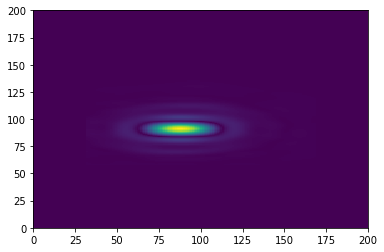

In [161]:
plt.pcolormesh(np.abs(fields[0].sum(axis=2)))

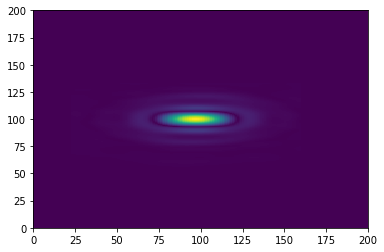

In [162]:
plt.pcolormesh(np.abs(fields_before_rotation1[0].sum(axis=2)))

In [163]:
np.shape(fields)

(4, 200, 200, 26)

In [164]:
phase_cross_correlation(fields[0,...,10], fields_before_rotation1[0,...,10])

(array([-9., -9.]), 0.20881019028571243, -2.215357588022672)

In [177]:
np.set_printoptions(precision=2)

In [201]:
for i in range(4):
    print(i, 'diffsums', *['%2.4f'%el[i].sum() for el in [sm1.simulations_per_peak[0].diffraction_patterns, 
                                               diffraction_patterns1, diffraction_patterns12]])
    r1, r2 = [phase_cross_correlation(fields[i].sum(axis=2), f[i].sum(axis=2)) for f in [fields1, fields12]]
    print('fld', *[f'{r[0]}, {r[1]:3.2}' for r in [r1, r2]])
    r3, r4 = [phase_cross_correlation(projs[i], p[i]) for p in [projections_all1, projections_all12]]
    print('proj', *[f'{r[0]}, {r[1]:3.2}' for r in [r3, r4]])
    
    print()
    

0 diffsums 0.0726 0.2210 0.0734
fld [-9. -8.], 0.28 [0. 0.], 1.1e-08
proj [-4.  5.], 0.57 [0. 0.], 0.043

1 diffsums 0.1761 0.2231 0.1778
fld [-9.  0.], 0.14 [0. 0.], 0.0
proj [-6.  6.], 0.23 [0. 0.], 0.034

2 diffsums 0.1370 0.2194 0.1380
fld [ 0. -8.], 0.21 [0. 0.], 2.6e-08
proj [ 1. -3.], 0.34 [0. 0.], 0.036

3 diffsums 0.2224 0.2224 0.2243
fld [0. 0.], 1.5e-08 [0. 0.], 1.5e-08
proj [0. 0.], 0.0 [0. 0.], 0.033



In [89]:

sm2 = SimulationModified(sim_params={'poisson_noise':False, 
                                    'probes_matlab_file':probes_3d_path, 
                                    'n_scan_positions':9,
                                    'npix_scan_shift':6,
                                      'HKL_list':np.array([[1, 2, 0]]),
                                     'magnitudes_scaling_per_peak': [0.004]},
                      extra_sample_params={'strain_type':strain_type, 
                                               'npix_uncertainty_x':5,
                                               'npix_uncertainty_y':5},
                       z_nw_pad=30)
sm2.sample.Ux_trunc.shape, sm2.sample.params.sample_pix_size

Depth of numerical window covers 0.5844363636363636 microns
uncertainty 0.029221818181818182 0.029221818181818182
Magnitude scaling per peak is supplied. Does not apply random scaling.
Loading probe from matlab data...
Loading successful...
Truncated probe shape (162, 200, 76)


((200, 200, 76), 0.005844363636363636)

In [92]:
projections_this = np.array(sm2.simulations_per_peak[0].projections)
diffs_this = sm2.simulations_per_peak[0].diffraction_patterns

In [100]:
for i in range(81):
    print(phase_cross_correlation(projections_this[i], sm1.simulations_per_peak[0].projections[i]))

(array([ -5., -18.]), 0.8613916952248695, 1.3464597154690499)
(array([ -5., -18.]), 0.8624790621463224, 1.5778571379959416)
(array([ -1., -20.]), 0.9024557841293251, 2.1070270617100615)
(array([ -8., -22.]), 0.8880967859674582, -0.3859872801874559)
(array([-2., -6.]), 0.694258240625489, -0.2878138110490223)
(array([-1., -4.]), 0.48061723546245266, -0.20328263250577935)
(array([-1., -2.]), 0.32260168533778183, -0.17666001432205428)
(array([0., 0.]), 0.2443289861963813, 0.008839325250777269)
(array([0., 1.]), 0.3278199088431428, 0.09804898744773913)
(array([ -5., -18.]), 0.860323406781873, 1.4266711211092196)
(array([ -4., -19.]), 0.8883441622857352, 1.6119216052623546)
(array([  1., -22.]), 0.9235646673015849, 2.28246408834552)
(array([ -6., -17.]), 0.7798356731520911, -0.563488631535224)
(array([-2., -6.]), 0.5591612862601387, -0.3486214417256275)
(array([-1., -3.]), 0.3676815967898742, -0.21535730749701737)
(array([0., 0.]), 0.2698121051403762, -0.022961667350675345)
(array([0., 1.]),

In [121]:
np.min(sm2.simulations_per_peak[0].nw_rotated_coords_stacked, axis=1), np.max(sm2.simulations_per_peak[0].nw_rotated_coords_stacked, axis=1)

(array([-0.82047729, -0.55020157, -0.82629818]),
 array([0.8221575 , 0.55067841, 0.81632726]))

In [123]:
(np.min(sm2.simulations_per_peak[0].nw_rotated_masked_coords, axis=1), 
 np.max(sm2.simulations_per_peak[0].nw_rotated_masked_coords, axis=1))

(array([-0.25582699, -0.4054908 , -0.05583928]),
 array([0.25582699, 0.4054908 , 0.05583928]))

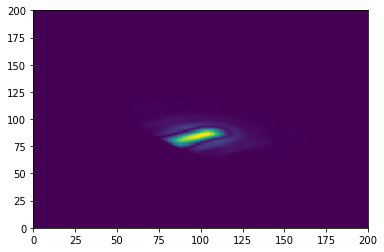

In [114]:
plt.pcolormesh(np.abs(projections_this[0]))

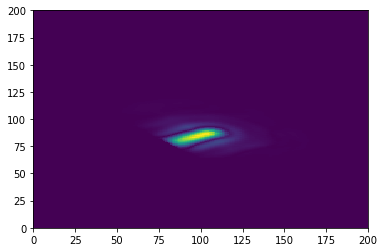

In [115]:
plt.pcolormesh(np.abs(projections_all12[0]))

In [116]:
np.abs(sm2.simulations_per_peak[0].projections[0] - projections_all12[0]).sum()

0.40242346603674384

In [77]:
np.shape(projections_all12)

(81, 200, 200)

In [37]:
diffraction_patterns1.sum(), sm1.simulations_per_peak[0].diffraction_patterns.sum(), diffraction_patterns12.sum()

(410731.1171879031, 411061.1772527675, 414517.2158529382)

In [33]:
diffraction_patterns1.sum(), sm1.simulations_per_peak[0].diffraction_patterns.sum(), diffraction_patterns12.sum()

(407025.8383017049, 385194.04367481585, 388661.08094277)

In [29]:
diffraction_patterns1.sum(), sm1.simulations_per_peak[0].diffraction_patterns.sum(), diffraction_patterns12.sum()

(354483.02334208984, 168790.64785045912, 170519.26852509467)

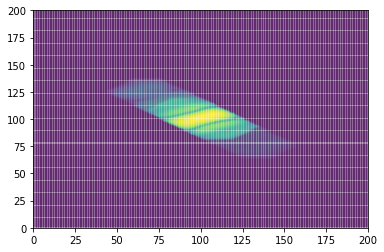

In [37]:
plt.pcolormesh(np.log(np.abs(projections_all1[0]) + 1e-5), alpha=0.2)
plt.pcolormesh(np.log(np.abs(projections_all1[80]) + 1e-5), alpha=0.2)

In [39]:
projections_all1[0].sum()

(3.773884562399477+3.9657477187296566j)

In [41]:
projections_all1[80].sum()

(2.5231413119115045+5.585528162363833j)

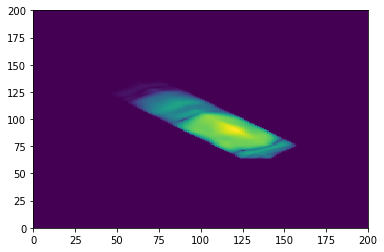

In [27]:
plt.pcolormesh(np.log(np.abs(sm1.simulations_per_peak[0].projections[0]) + 1e-5))

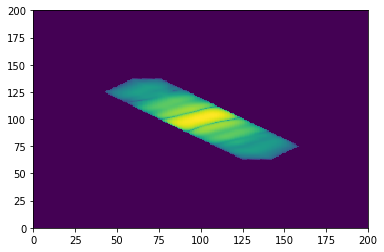

In [29]:
plt.pcolormesh(np.log(np.sum(np.abs(projections_all1),axis=0) + 1e-5))

In [42]:
# The "magnitudes_scaling_per_peak" parameter sets the scattering amplitude per peak.

sm2 = SimulationModified(sim_params={'poisson_noise':False, 
                                    'probes_matlab_file':probes_3d_path, 
                                    'n_scan_positions':9,
                                    'npix_scan_shift':6,
                                      'HKL_list':np.array([[1, 2, 0]]),
                                     'magnitudes_scaling_per_peak': [0.004]},
                      extra_sample_params={'strain_type':strain_type, 
                                               'npix_uncertainty_x':5,
                                               'npix_uncertainty_y':5},
                       z_nw_pad=5)
sm2.sample.Ux_trunc.shape, sm2.sample.params.sample_pix_size

Depth of numerical window covers 0.5844363636363636 microns
uncertainty 0.029221818181818182 0.029221818181818182
Magnitude scaling per peak is supplied. Does not apply random scaling.
Loading probe from matlab data...
Loading successful...
Truncated probe shape (162, 200, 26)


((200, 200, 26), 0.005844363636363636)

In [43]:
[diffraction_patterns2, 
 projections_all2] = sm2.simulations_per_peak[0].getDiffractionPatternsNew()

In [55]:
diffraction_patterns2.sum(), diffraction_patterns1.sum()

(404929.38326459477, 354483.02334208984)

In [49]:
sm1.simulations_per_peak[0].diffraction_patterns[0].sum(), sm2.simulations_per_peak[0].diffraction_patterns[0].sum()

(29.11452246258974, 51.68660803556271)

In [18]:
# The "magnitudes_scaling_per_peak" parameter sets the scattering amplitude per peak.

sm3 = SimulationModified(sim_params={'poisson_noise':False, 
                                    'probes_matlab_file':probes_3d_path, 
                                    'n_scan_positions':9,
                                    'npix_scan_shift':6,
                                      'HKL_list':np.array([[1, 2, 0]]),
                                     'magnitudes_scaling_per_peak': [0.004]},
                      extra_sample_params={'strain_type':strain_type, 
                                               'npix_uncertainty_x':5,
                                               'npix_uncertainty_y':5},
                       z_nw_pad=10)
sm3.sample.Ux_trunc.shape, sm3.sample.params.sample_pix_size

Depth of numerical window covers 0.5844363636363636 microns
uncertainty 0.029221818181818182 0.029221818181818182
Magnitude scaling per peak is supplied. Does not apply random scaling.
Loading probe from matlab data...
Loading successful...
Truncated probe shape (162, 200, 36)


((200, 200, 36), 0.005844363636363636)

In [19]:
# The "magnitudes_scaling_per_peak" parameter sets the scattering amplitude per peak.

sm4 = SimulationModified(sim_params={'poisson_noise':False, 
                                    'probes_matlab_file':probes_3d_path, 
                                    'n_scan_positions':9,
                                    'npix_scan_shift':6,
                                      'HKL_list':np.array([[1, 2, 0]]),
                                     'magnitudes_scaling_per_peak': [0.004]},
                      extra_sample_params={'strain_type':strain_type, 
                                               'npix_uncertainty_x':5,
                                               'npix_uncertainty_y':5},
                       z_nw_pad=20)
sm4.sample.Ux_trunc.shape, sm4.sample.params.sample_pix_size

Depth of numerical window covers 0.5844363636363636 microns
uncertainty 0.029221818181818182 0.029221818181818182
Magnitude scaling per peak is supplied. Does not apply random scaling.
Loading probe from matlab data...
Loading successful...
Truncated probe shape (162, 200, 56)


((200, 200, 56), 0.005844363636363636)

In [20]:
# The "magnitudes_scaling_per_peak" parameter sets the scattering amplitude per peak.

sm5 = SimulationModified(sim_params={'poisson_noise':False, 
                                    'probes_matlab_file':probes_3d_path, 
                                    'n_scan_positions':9,
                                    'npix_scan_shift':6,
                                      'HKL_list':np.array([[1, 2, 0]]),
                                     'magnitudes_scaling_per_peak': [0.004]},
                      extra_sample_params={'strain_type':strain_type, 
                                               'npix_uncertainty_x':5,
                                               'npix_uncertainty_y':5},
                       z_nw_pad=30)
sm5.sample.Ux_trunc.shape, sm5.sample.params.sample_pix_size

Depth of numerical window covers 0.5844363636363636 microns
uncertainty 0.029221818181818182 0.029221818181818182
Magnitude scaling per peak is supplied. Does not apply random scaling.
Loading probe from matlab data...
Loading successful...
Truncated probe shape (162, 200, 76)


((200, 200, 76), 0.005844363636363636)

In [21]:
# The "magnitudes_scaling_per_peak" parameter sets the scattering amplitude per peak.

sm6 = SimulationModified(sim_params={'poisson_noise':False, 
                                    'probes_matlab_file':probes_3d_path, 
                                    'n_scan_positions':9,
                                    'npix_scan_shift':6,
                                      'HKL_list':np.array([[1, 2, 0]]),
                                     'magnitudes_scaling_per_peak': [0.004]},
                      extra_sample_params={'strain_type':strain_type, 
                                               'npix_uncertainty_x':5,
                                               'npix_uncertainty_y':5},
                       z_nw_pad=50)
sm6.sample.Ux_trunc.shape, sm6.sample.params.sample_pix_size

Depth of numerical window covers 0.5844363636363636 microns
uncertainty 0.029221818181818182 0.029221818181818182
Magnitude scaling per peak is supplied. Does not apply random scaling.
Loading probe from matlab data...
Loading successful...
Truncated probe shape (162, 200, 100)


((200, 200, 100), 0.005844363636363636)

In [50]:
# The "magnitudes_scaling_per_peak" parameter sets the scattering amplitude per peak.

sm7 = SimulationModified(sim_params={'poisson_noise':False, 
                                    'probes_matlab_file':probes_3d_path, 
                                    'n_scan_positions':9,
                                    'npix_scan_shift':6,
                                      'HKL_list':np.array([[1, 2, 0]]),
                                     'magnitudes_scaling_per_peak': [0.004]},
                      extra_sample_params={'strain_type':strain_type, 
                                               'npix_uncertainty_x':5,
                                               'npix_uncertainty_y':5},
                       z_nw_pad=80)
sm6.sample.Ux_trunc.shape, sm6.sample.params.sample_pix_size

Depth of numerical window covers 0.5844363636363636 microns
uncertainty 0.029221818181818182 0.029221818181818182
Magnitude scaling per peak is supplied. Does not apply random scaling.
Loading probe from matlab data...
Loading successful...
Truncated probe shape (162, 200, 100)


NameError: name 'sm6' is not defined

In [52]:
[diffraction_patterns7, 
 projections_all7] = sm7.simulations_per_peak[0].getDiffractionPatternsNew()

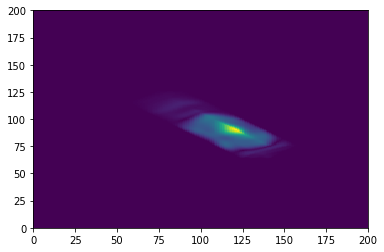

In [80]:
plt.pcolormesh(np.abs(sm1.simulations_per_peak[0].projections[0]))

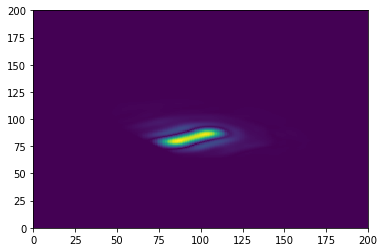

In [81]:

plt.pcolormesh(np.abs(sm7.simulations_per_peak[0].projections[0]))

In [58]:
sm7.simulations_per_peak[0].diffraction_patterns.sum(), diffraction_patterns7.sum()

(411442.05615645694, 411401.08004467376)

In [23]:
np.abs(sm1.simulations_per_peak[0].diffraction_patterns - sm4.simulations_per_peak[0].diffraction_patterns).sum()

249457.70521044976

In [24]:
np.abs(sm2.simulations_per_peak[0].diffraction_patterns - sm4.simulations_per_peak[0].diffraction_patterns).sum()

202300.85062206353

In [25]:
np.abs(sm3.simulations_per_peak[0].diffraction_patterns - sm4.simulations_per_peak[0].diffraction_patterns).sum()

127859.38763631308

In [26]:
np.abs(sm5.simulations_per_peak[0].diffraction_patterns - sm4.simulations_per_peak[0].diffraction_patterns).sum()

57319.106199002985

In [27]:
np.abs(sm5.simulations_per_peak[0].diffraction_patterns - sm6.simulations_per_peak[0].diffraction_patterns).sum()

20439.567538073276

In [28]:
np.abs(sm6.simulations_per_peak[0].diffraction_patterns - sm7.simulations_per_peak[0].diffraction_patterns).sum()

0.0

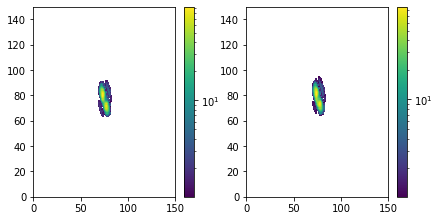

1751.7402532674514
[(94.54322634445624, 5179.738921931208)]
(81, 150, 150)


In [29]:
fig = plt.figure(figsize=[7,3.5])
plt.subplot(1,2,1)

data_out = np.fft.fftshift(sm7.simulations_per_peak[0].diffraction_patterns[0])
data_out[data_out < 1.] = 0
plt.pcolormesh(data_out,
               norm=mpl.colors.LogNorm())
plt.colorbar()
plt.subplot(1,2,2)

data_out = np.fft.fftshift(sm7.simulations_per_peak[0].diffraction_patterns[15])
data_out[data_out < 1.] = 0
plt.pcolormesh(data_out,
               norm=mpl.colors.LogNorm())
plt.colorbar()
plt.show()
print(np.abs(sm7.simulations_per_peak[0].diffraction_patterns[0] - 
             sm7.simulations_per_peak[0].diffraction_patterns[30]).sum())

print([(sm7.simulations_per_peak[i].diffraction_patterns.max(),
        sm7.simulations_per_peak[i].diffraction_patterns.sum(axis=(1,2)).max())
       for i in range(1)])
print(sm7.simulations_per_peak[0].diffraction_patterns.shape)

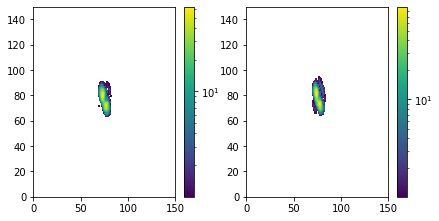

2226.501512209029
[(98.38828326414098, 5290.905517942331)]
(81, 150, 150)


In [30]:
fig = plt.figure(figsize=[7,3.5])
plt.subplot(1,2,1)

data_out = np.fft.fftshift(sm5.simulations_per_peak[0].diffraction_patterns[0])
data_out[data_out < 1.] = 0
plt.pcolormesh(data_out,
               norm=mpl.colors.LogNorm())
plt.colorbar()
plt.subplot(1,2,2)

data_out = np.fft.fftshift(sm5.simulations_per_peak[0].diffraction_patterns[15])
data_out[data_out < 1.] = 0
plt.pcolormesh(data_out,
               norm=mpl.colors.LogNorm())
plt.colorbar()
plt.show()
print(np.abs(sm5.simulations_per_peak[0].diffraction_patterns[0] - 
             sm5.simulations_per_peak[0].diffraction_patterns[30]).sum())

print([(sm5.simulations_per_peak[i].diffraction_patterns.max(),
        sm5.simulations_per_peak[i].diffraction_patterns.sum(axis=(1,2)).max())
       for i in range(1)])
print(sm5.simulations_per_peak[0].diffraction_patterns.shape)

In [32]:
sp = sm7.simulations_per_peak[0]

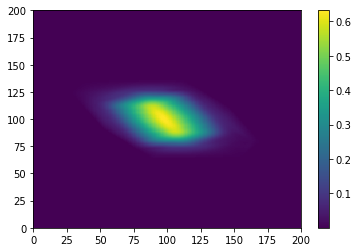

In [33]:
plt.pcolormesh(np.sum(np.abs(sp.projections) , axis=0)+ 1e-5)
plt.colorbar()

In [35]:
sps  = [s.simulations_per_peak[0] for s in [sm1, sm2, sm3, sm4, sm5, sm6, sm7]]

In [37]:
sps[0].nw_coords_stacked, sps[1].nw_coords_stacked

(array([[-0.58443636, -0.58443636, -0.58443636, ...,  0.578592  ,
          0.578592  ,  0.578592  ],
        [-0.58443636, -0.58443636, -0.58443636, ...,  0.578592  ,
          0.578592  ,  0.578592  ],
        [-0.05844364, -0.05259927, -0.04675491, ...,  0.04091055,
          0.04675491,  0.05259927]]),
 array([[-0.58443636, -0.58443636, -0.58443636, ...,  0.578592  ,
          0.578592  ,  0.578592  ],
        [-0.58443636, -0.58443636, -0.58443636, ...,  0.578592  ,
          0.578592  ,  0.578592  ],
        [-0.07597673, -0.07013236, -0.064288  , ...,  0.05844364,
          0.064288  ,  0.07013236]]))

In [41]:
sm6.probes[0].shape

(200, 200, 100)

In [40]:
sm1.probes[0].shape

(200, 200, 20)

In [46]:
np.sum(np.abs(sm6.probes[0]), axis=(1,2))

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.77359492e-05, 1.98166166e-04, 8.14503705e-04,
       3.41337229e-03, 7.51287387e-03, 1.70740980e-02, 2.71384426e-02,
       3.90528914e-02, 5.29434498e-02, 8.21855629e-02, 1.34678426e-01,
       1.90368410e-01, 2.63180484e-01, 3.74756667e-01, 5.43369521e-01,
       7.73361393e-01, 9.65286691e-01, 1.13758917e+00, 1.19156264e+00,
       1.22172528e+00, 1.61433621e+00, 2.21904293e+00, 2.83871498e+00,
       3.41417039e+00, 3.67923617e+00, 4.49593853e+00, 5.71166203e+00,
       7.14580175e+00, 8.64837016e+00, 9.83261050e+00, 1.10127523e+01,
       1.23762140e+01, 1.36665261e+01, 1.51555341e+01, 1.64775980e+01,
      